# IMAGE CLASSIFICATIONS

## All necessary imports


In [2]:
# Part 1: 
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from skimage.feature import hog, local_binary_pattern
from scipy.stats import skew, kurtosis
import time
import pickle
import warnings
warnings.filterwarnings('ignore')



## Import CIFAR10AnimalClassifier datasets and handle features


In [3]:
class CIFAR10AnimalClassifier:
    def __init__(self):
        self.animal_classes = {
            2: 'bird',
            3: 'cat', 
            4: 'deer',
            5: 'dog',
            6: 'frog',
            7: 'horse'
        }
        self.scaler = StandardScaler()
        self.pca = None
        self.models = {}
        
    def load_animal_data(self):
        """Load CIFAR-10 and extract only animal classes"""
        print("Loading CIFAR-10 dataset...")
        (X_train, y_train), (X_test, y_test) = cifar10.load_data()
        
        # Flatten labels
        y_train = y_train.flatten()
        y_test = y_test.flatten()
        
        # Get animal indices
        animal_indices = list(self.animal_classes.keys())
        
        # Filter for animals only
        train_mask = np.isin(y_train, animal_indices)
        test_mask = np.isin(y_test, animal_indices)
        
        X_train_animals = X_train[train_mask]
        y_train_animals = y_train[train_mask]
        X_test_animals = X_test[test_mask]
        y_test_animals = y_test[test_mask]
        
        # Remap labels to 0-5
        label_mapping = {old_label: new_label for new_label, old_label in enumerate(animal_indices)}
        
        y_train_remapped = np.array([label_mapping[label] for label in y_train_animals])
        y_test_remapped = np.array([label_mapping[label] for label in y_test_animals])
        
        print(f"\nDataset loaded successfully!")
        print(f"Training samples: {len(X_train_animals)}")
        print(f"Test samples: {len(X_test_animals)}")
        print(f"Image shape: {X_train_animals[0].shape}")
        print(f"Classes: {list(self.animal_classes.values())}")
        
        return X_train_animals, y_train_remapped, X_test_animals, y_test_remapped
    
    def extract_color_histogram(self, image, bins=32):
        """Extract color histogram features"""
        features = []
        
        # RGB histograms
        for channel in range(3):
            hist = cv2.calcHist([image], [channel], None, [bins], [0, 256])
            hist = hist.flatten() / (hist.sum() + 1e-6)
            features.extend(hist)
        
        # Convert to HSV and extract histograms
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        for channel in range(3):
            hist = cv2.calcHist([hsv], [channel], None, [bins], [0, 256])
            hist = hist.flatten() / (hist.sum() + 1e-6)
            features.extend(hist)
        
        # Convert to LAB
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        for channel in range(3):
            hist = cv2.calcHist([lab], [channel], None, [bins], [0, 256])
            hist = hist.flatten() / (hist.sum() + 1e-6)
            features.extend(hist)
            
        return np.array(features)
        # Initialize classifier

    
    def extract_texture_features(self, image):
        """Extract texture-based features"""
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        features = []
        
        # Basic statistics
        features.extend([
            np.mean(gray),
            np.std(gray),
            np.median(gray),
            skew(gray.ravel()),
            kurtosis(gray.ravel())
        ])
        
        # Gabor filter responses
        kernels = []
        for theta in range(4):  # 4 orientations
            theta = theta / 4. * np.pi
            for freq in [0.1, 0.5]:
                kernel = cv2.getGaborKernel((5, 5), 1.0, theta, freq, 0.5, 0, ktype=cv2.CV_32F)
                kernels.append(kernel)
        
        for kernel in kernels:
            filtered = cv2.filter2D(gray, cv2.CV_8UC3, kernel)
            features.extend([np.mean(filtered), np.std(filtered)])
        
        # Edge features
        edges = cv2.Canny(gray, 50, 150)
        features.append(np.sum(edges > 0) / edges.size)  # Edge density
        
        # Laplacian
        laplacian = cv2.Laplacian(gray, cv2.CV_64F)
        features.extend([np.mean(np.abs(laplacian)), np.std(laplacian)])
        
        return np.array(features)
    
    def extract_hog_features(self, image):
        """Extract HOG features"""
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        features = hog(gray,
                      orientations=9,
                      pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2),
                      feature_vector=True)
        
        return features
    
    def extract_lbp_features(self, image, n_points=24, radius=3):
        """Extract Local Binary Pattern features"""
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
        
        # Calculate histogram
        hist, _ = np.histogram(lbp.ravel(),
                              bins=np.arange(0, n_points + 3),
                              range=(0, n_points + 2))
        
        # Normalize
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)
        
        return hist
    
    def extract_color_moments(self, image):
        """Extract color moments (mean, std, skewness)"""
        features = []
        
        # For each channel
        for channel in range(3):
            channel_data = image[:, :, channel].ravel()
            features.extend([
                np.mean(channel_data),
                np.std(channel_data),
                skew(channel_data)
            ])
        
        # HSV color space
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        for channel in range(3):
            channel_data = hsv[:, :, channel].ravel()
            features.extend([
                np.mean(channel_data),
                np.std(channel_data),
                skew(channel_data)
            ])
            
        return np.array(features)
    
    def extract_all_features(self, image):
        """Extract all features from an image"""
        # Resize image for HOG
        image_resized = cv2.resize(image, (64, 64))
        
        # Extract different feature types
        color_hist = self.extract_color_histogram(image)
        texture_feat = self.extract_texture_features(image)
        hog_feat = self.extract_hog_features(image_resized)
        lbp_feat = self.extract_lbp_features(image)
        color_moments = self.extract_color_moments(image)
        
        # Concatenate all features
        all_features = np.concatenate([
            color_hist,
            texture_feat,
            hog_feat,
            lbp_feat,
            color_moments
        ])
        
        return all_features
    
    def extract_features_from_dataset(self, X):
        """Extract features from all images"""
        features = []
        
        print("Extracting features...")
        for i, image in enumerate(X):
            if i % 100 == 0:
                print(f"Processing image {i}/{len(X)}")
            
            feat = self.extract_all_features(image)
            features.append(feat)
        
        return np.array(features)
    
    
    
   

In [4]:
# Initialize classifier
classifier = CIFAR10AnimalClassifier()

# Load the data - THIS IS THE IMPORTANT PART YOU'RE MISSING
X_train, y_train, X_test, y_test = classifier.load_animal_data()

Loading CIFAR-10 dataset...

Dataset loaded successfully!
Training samples: 30000
Test samples: 6000
Image shape: (32, 32, 3)
Classes: ['bird', 'cat', 'deer', 'dog', 'frog', 'horse']


## Training and Evaluating datasets

In [5]:
class CIFAR10AnimalClassifier:
    def __init__(self):
        self.animal_classes = {
            2: 'bird',
            3: 'cat', 
            4: 'deer',
            5: 'dog',
            6: 'frog',
            7: 'horse'
        }
        self.scaler = StandardScaler()
        self.pca = None
        self.models = {}
        
    def load_animal_data(self):
        """Load CIFAR-10 and extract only animal classes"""
        print("Loading CIFAR-10 dataset...")
        (X_train, y_train), (X_test, y_test) = cifar10.load_data()
        
        # Flatten labels
        y_train = y_train.flatten()
        y_test = y_test.flatten()
        
        # Get animal indices
        animal_indices = list(self.animal_classes.keys())
        
        # Filter for animals only
        train_mask = np.isin(y_train, animal_indices)
        test_mask = np.isin(y_test, animal_indices)
        
        X_train_animals = X_train[train_mask]
        y_train_animals = y_train[train_mask]
        X_test_animals = X_test[test_mask]
        y_test_animals = y_test[test_mask]
        
        # Remap labels to 0-5
        label_mapping = {old_label: new_label for new_label, old_label in enumerate(animal_indices)}
        
        y_train_remapped = np.array([label_mapping[label] for label in y_train_animals])
        y_test_remapped = np.array([label_mapping[label] for label in y_test_animals])
        
        print(f"\nDataset loaded successfully!")
        print(f"Training samples: {len(X_train_animals)}")
        print(f"Test samples: {len(X_test_animals)}")
        print(f"Image shape: {X_train_animals[0].shape}")
        print(f"Classes: {list(self.animal_classes.values())}")
        
        return X_train_animals, y_train_remapped, X_test_animals, y_test_remapped
    
    def extract_color_histogram(self, image, bins=32):
        """Extract color histogram features"""
        features = []
        
        # RGB histograms
        for channel in range(3):
            hist = cv2.calcHist([image], [channel], None, [bins], [0, 256])
            hist = hist.flatten() / (hist.sum() + 1e-6)
            features.extend(hist)
        
        # Convert to HSV and extract histograms
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        for channel in range(3):
            hist = cv2.calcHist([hsv], [channel], None, [bins], [0, 256])
            hist = hist.flatten() / (hist.sum() + 1e-6)
            features.extend(hist)
        
        # Convert to LAB
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        for channel in range(3):
            hist = cv2.calcHist([lab], [channel], None, [bins], [0, 256])
            hist = hist.flatten() / (hist.sum() + 1e-6)
            features.extend(hist)
            
        return np.array(features)
    
    def extract_texture_features(self, image):
        """Extract texture-based features"""
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        features = []
        
        # Basic statistics
        features.extend([
            np.mean(gray),
            np.std(gray),
            np.median(gray),
            skew(gray.ravel()),
            kurtosis(gray.ravel())
        ])
        
        # Gabor filter responses
        kernels = []
        for theta in range(4):  # 4 orientations
            theta = theta / 4. * np.pi
            for freq in [0.1, 0.5]:
                kernel = cv2.getGaborKernel((5, 5), 1.0, theta, freq, 0.5, 0, ktype=cv2.CV_32F)
                kernels.append(kernel)
        
        for kernel in kernels:
            filtered = cv2.filter2D(gray, cv2.CV_8UC3, kernel)
            features.extend([np.mean(filtered), np.std(filtered)])
        
        # Edge features
        edges = cv2.Canny(gray, 50, 150)
        features.append(np.sum(edges > 0) / edges.size)  # Edge density
        
        # Laplacian
        laplacian = cv2.Laplacian(gray, cv2.CV_64F)
        features.extend([np.mean(np.abs(laplacian)), np.std(laplacian)])
        
        return np.array(features)
    
    def extract_hog_features(self, image):
        """Extract HOG features"""
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        features = hog(gray,
                      orientations=9,
                      pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2),
                      feature_vector=True)
        
        return features
    
    def extract_lbp_features(self, image, n_points=24, radius=3):
        """Extract Local Binary Pattern features"""
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
        
        # Calculate histogram
        hist, _ = np.histogram(lbp.ravel(),
                              bins=np.arange(0, n_points + 3),
                              range=(0, n_points + 2))
        
        # Normalize
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)
        
        return hist
    
    def extract_color_moments(self, image):
        """Extract color moments (mean, std, skewness)"""
        features = []
        
        # For each channel
        for channel in range(3):
            channel_data = image[:, :, channel].ravel()
            features.extend([
                np.mean(channel_data),
                np.std(channel_data),
                skew(channel_data)
            ])
        
        # HSV color space
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        for channel in range(3):
            channel_data = hsv[:, :, channel].ravel()
            features.extend([
                np.mean(channel_data),
                np.std(channel_data),
                skew(channel_data)
            ])
            
        return np.array(features)
    
    def extract_all_features(self, image):
        """Extract all features from an image"""
        # Resize image for HOG
        image_resized = cv2.resize(image, (64, 64))
        
        # Extract different feature types
        color_hist = self.extract_color_histogram(image)
        texture_feat = self.extract_texture_features(image)
        hog_feat = self.extract_hog_features(image_resized)
        lbp_feat = self.extract_lbp_features(image)
        color_moments = self.extract_color_moments(image)
        
        # Concatenate all features
        all_features = np.concatenate([
            color_hist,
            texture_feat,
            hog_feat,
            lbp_feat,
            color_moments
        ])
        all_features = np.nan_to_num(all_features, nan=0.0, posinf=0.0, neginf=0.0)
        return all_features
    
    def extract_features_from_dataset(self, X):
        """Extract features from all images"""
        features = []
        
        print("Extracting features...")
        for i, image in enumerate(X):
            if i % 100 == 0:
                print(f"Processing image {i}/{len(X)}")
            
            feat = self.extract_all_features(image)
            features.append(feat)
            features_array = np.array(features)
    
    # Double-check and clean
        if np.any(np.isnan(features_array)) or np.any(np.isinf(features_array)):
            print("Warning: Found NaN or Inf values, cleaning...")
            features_array = np.nan_to_num(features_array, nan=0.0, posinf=0.0, neginf=0.0)
    
        return features_array
        
    
    def train_models(self, X_train, y_train, use_pca=True, n_components=100):
        """Train multiple classifiers"""
        print("\nTraining models...")
        if np.any(np.isnan(X_train)) or np.any(np.isinf(X_train)):
            print("Cleaning training data...")
            X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        
        # Apply PCA if requested
        if use_pca and n_components < X_train_scaled.shape[1]:
            print(f"Applying PCA: {X_train_scaled.shape[1]} -> {n_components} components")
            self.pca = PCA(n_components=n_components, random_state=42)
            X_train_scaled = self.pca.fit_transform(X_train_scaled)
            
            # Print explained variance
            explained_var = np.sum(self.pca.explained_variance_ratio_)
            print(f"Explained variance: {explained_var:.2%}")
        
        # Define models
        models = {
            'SVM (Linear)': SVC(kernel='linear', C=1.0, random_state=42),
            'SVM (RBF)': SVC(kernel='rbf', C=10.0, gamma=0.001, random_state=42),
            'Random Forest': RandomForestClassifier(
                n_estimators=200, 
                max_depth=20,
                min_samples_split=5,
                random_state=42,
                n_jobs=-1
            ),
            'Gradient Boosting': GradientBoostingClassifier(
                n_estimators=100,
                learning_rate=0.1,
                max_depth=5,
                random_state=42
            ),
            'KNN': KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
        }
        
        # Train each model
        for name, model in models.items():
            print(f"\nTraining {name}...")
            start_time = time.time()
            
            model.fit(X_train_scaled, y_train)
            
            # Cross-validation
            cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=3, n_jobs=-1)
            
            train_time = time.time() - start_time
            print(f"Training time: {train_time:.2f}s")
            print(f"Cross-validation accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
            
            self.models[name] = model
    
    def evaluate_models(self, X_test, y_test):
        """Evaluate all trained models"""
        if np.any(np.isnan(X_test)) or np.any(np.isinf(X_test)):
            print("Cleaning test data...")
            X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)
        # Scale and transform test data
        
        X_test_scaled = self.scaler.transform(X_test)
        
        if self.pca is not None:
            X_test_scaled = self.pca.transform(X_test_scaled)
        
        results = {}
        animal_names = list(self.animal_classes.values())
        
        print("\n" + "="*60)
        print("MODEL EVALUATION RESULTS")
        print("="*60)
        
        for name, model in self.models.items():
            print(f"\n{name}:")
            print("-" * 40)
            
            # Predictions
            y_pred = model.predict(X_test_scaled)
            
            # Accuracy
            accuracy = accuracy_score(y_test, y_pred)
            print(f"Accuracy: {accuracy:.4f}")
            
            # Detailed classification report
            report = classification_report(y_test, y_pred, 
                                         target_names=animal_names,
                                         output_dict=True)
            
            # Print per-class metrics
            print("\nPer-class metrics:")
            for animal in animal_names:
                precision = report[animal]['precision']
                recall = report[animal]['recall']
                f1 = report[animal]['f1-score']
                print(f"{animal:10s} - Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")
            
            results[name] = {
                'accuracy': accuracy,
                'predictions': y_pred,
                'report': report,
                'confusion_matrix': confusion_matrix(y_test, y_pred)
            }
        
        return results
    
    def plot_confusion_matrices(self, results, y_test):
        """Plot confusion matrices for all models"""
        animal_names = list(self.animal_classes.values())
        
        n_models = len(results)
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.ravel()
        
        for idx, (name, result) in enumerate(results.items()):
            cm = result['confusion_matrix']
            
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=animal_names,
                       yticklabels=animal_names,
                       ax=axes[idx])
            
            axes[idx].set_title(f'{name}\nAccuracy: {result["accuracy"]:.3f}')
            axes[idx].set_ylabel('True Label')
            axes[idx].set_xlabel('Predicted Label')
        
        # Hide extra subplots if any
        for idx in range(n_models, len(axes)):
            axes[idx].set_visible(False)
        
        plt.tight_layout()
        plt.show()
    
    def visualize_predictions(self, X_test, y_test, results, n_samples=10):
        """Visualize sample predictions"""
        # Get best model
        best_model_name = max(results.items(), key=lambda x: x[1]['accuracy'])[0]
        best_predictions = results[best_model_name]['predictions']
        
        # Random samples
        indices = np.random.choice(len(X_test), n_samples, replace=False)
        
        fig, axes = plt.subplots(2, 5, figsize=(15, 6))
        axes = axes.ravel()
        
        animal_names = list(self.animal_classes.values())
        
        for i, idx in enumerate(indices):
            axes[i].imshow(X_test[idx])
            axes[i].set_title(f'True: {animal_names[y_test[idx]]}\n'
                            f'Pred: {animal_names[best_predictions[idx]]}',
                            color='green' if y_test[idx] == best_predictions[idx] else 'red')
            axes[i].axis('off')
        
        plt.suptitle(f'Sample Predictions using {best_model_name}')
        plt.show()
    

    
    def plot_feature_importance(self):
        """Plot feature importance from Random Forest"""
        if 'Random Forest' not in self.models:
            print("Random Forest model not found!")
            return
        
        rf_model = self.models['Random Forest']
        importances = rf_model.feature_importances_
        indices = np.argsort(importances)[::-1][:20]  # Top 20 features
        
        plt.figure(figsize=(10, 6))
        plt.title("Top 20 Most Important Features")
        plt.bar(range(20), importances[indices])
        plt.xlabel("Feature Index")
        plt.ylabel("Importance")
        plt.tight_layout()
        plt.show()
    
    def save_models(self, filepath='cifar10_animal_models.pkl'):
        """Save trained models"""
        save_dict = {
            'models': self.models,
            'scaler': self.scaler,
            'pca': self.pca,
            'animal_classes': self.animal_classes
        }
        
        with open(filepath, 'wb') as f:
            pickle.dump(save_dict, f)
        print(f"Models saved to {filepath}")
    
    def load_models(self, filepath='cifar10_animal_models.pkl'):
        """Load trained models"""
        with open(filepath, 'rb') as f:
            save_dict = pickle.load(f)
        
        self.models = save_dict['models']
        self.scaler = save_dict['scaler']
        self.pca = save_dict['pca']
        self.animal_classes = save_dict['animal_classes']
        print(f"Models loaded from {filepath}")

Loading CIFAR-10 dataset...

Dataset loaded successfully!
Training samples: 30000
Test samples: 6000
Image shape: (32, 32, 3)
Classes: ['bird', 'cat', 'deer', 'dog', 'frog', 'horse']

Visualizing sample images...


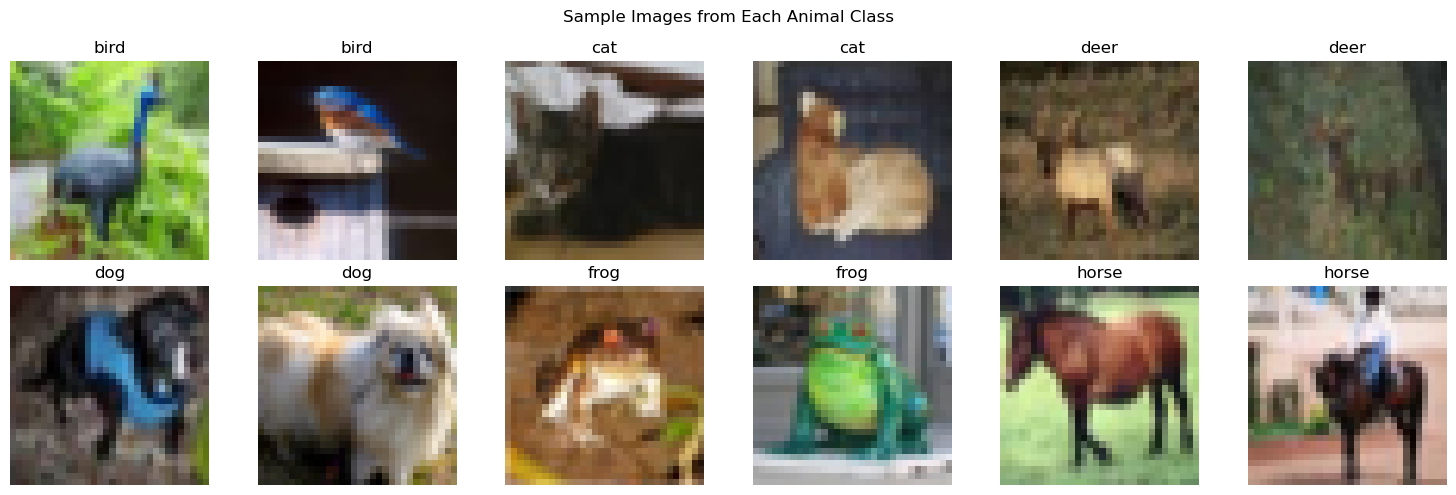


FEATURE EXTRACTION
Extracting features...
Processing image 0/5000
Processing image 100/5000
Processing image 200/5000
Processing image 300/5000
Processing image 400/5000
Processing image 500/5000
Processing image 600/5000
Processing image 700/5000
Processing image 800/5000
Processing image 900/5000
Processing image 1000/5000
Processing image 1100/5000
Processing image 1200/5000
Processing image 1300/5000
Processing image 1400/5000
Processing image 1500/5000
Processing image 1600/5000
Processing image 1700/5000
Processing image 1800/5000
Processing image 1900/5000
Processing image 2000/5000
Processing image 2100/5000
Processing image 2200/5000
Processing image 2300/5000
Processing image 2400/5000
Processing image 2500/5000
Processing image 2600/5000
Processing image 2700/5000
Processing image 2800/5000
Processing image 2900/5000
Processing image 3000/5000
Processing image 3100/5000
Processing image 3200/5000
Processing image 3300/5000
Processing image 3400/5000
Processing image 3500/50

In [6]:
# Main execution code
if __name__ == "__main__":
    # Initialize classifier
    classifier = CIFAR10AnimalClassifier()
    
    # Load data
    X_train, y_train, X_test, y_test = classifier.load_animal_data()
    
    # Visualize some samples
    print("\nVisualizing sample images...")
    fig, axes = plt.subplots(2, 6, figsize=(15, 5))
    axes = axes.ravel()
    
    for i in range(6):
        # Get 2 samples per class
        class_indices = np.where(y_train == i)[0][:2]
        for j, idx in enumerate(class_indices):
            axes[i*2 + j].imshow(X_train[idx])
            axes[i*2 + j].set_title(list(classifier.animal_classes.values())[i])
            axes[i*2 + j].axis('off')
    
    plt.suptitle("Sample Images from Each Animal Class")
    plt.tight_layout()
    plt.show()
    
    # Extract features (using subset for faster processing)
    print("\n" + "="*60)
    print("FEATURE EXTRACTION")
    print("="*60)
    
    # Adjust these numbers based on your computational resources
    train_subset_size = 5000  # Use 5000 training images
    test_subset_size = 1000   # Use 1000 test images
    
    # Create random subsets
    train_indices = np.random.choice(len(X_train), train_subset_size, replace=False)
    test_indices = np.random.choice(len(X_test), test_subset_size, replace=False)
    
    X_train_subset = X_train[train_indices]
    y_train_subset = y_train[train_indices]
    X_test_subset = X_test[test_indices]
    y_test_subset = y_test[test_indices]
    
    # Extract features
    X_train_features = classifier.extract_features_from_dataset(X_train_subset)
    X_test_features = classifier.extract_features_from_dataset(X_test_subset)
    
    print(f"\nFeature extraction complete!")
    print(f"Training features shape: {X_train_features.shape}")
    print(f"Test features shape: {X_test_features.shape}")


Training models...
Applying PCA: 2120 -> 100 components
Explained variance: 54.37%

Training SVM (Linear)...
Training time: 329.81s
Cross-validation accuracy: 0.4926 (+/- 0.0111)

Training SVM (RBF)...
Training time: 10.06s
Cross-validation accuracy: 0.5726 (+/- 0.0062)

Training Random Forest...
Training time: 10.87s
Cross-validation accuracy: 0.4930 (+/- 0.0175)

Training Gradient Boosting...
Training time: 511.09s
Cross-validation accuracy: 0.4896 (+/- 0.0140)

Training KNN...
Training time: 1.79s
Cross-validation accuracy: 0.4420 (+/- 0.0267)

MODEL EVALUATION RESULTS

SVM (Linear):
----------------------------------------
Accuracy: 0.5110

Per-class metrics:
bird       - Precision: 0.468, Recall: 0.451, F1: 0.459
cat        - Precision: 0.421, Recall: 0.500, F1: 0.457
deer       - Precision: 0.500, Recall: 0.503, F1: 0.501
dog        - Precision: 0.490, Recall: 0.386, F1: 0.432
frog       - Precision: 0.601, Recall: 0.664, F1: 0.631
horse      - Precision: 0.594, Recall: 0.597, F

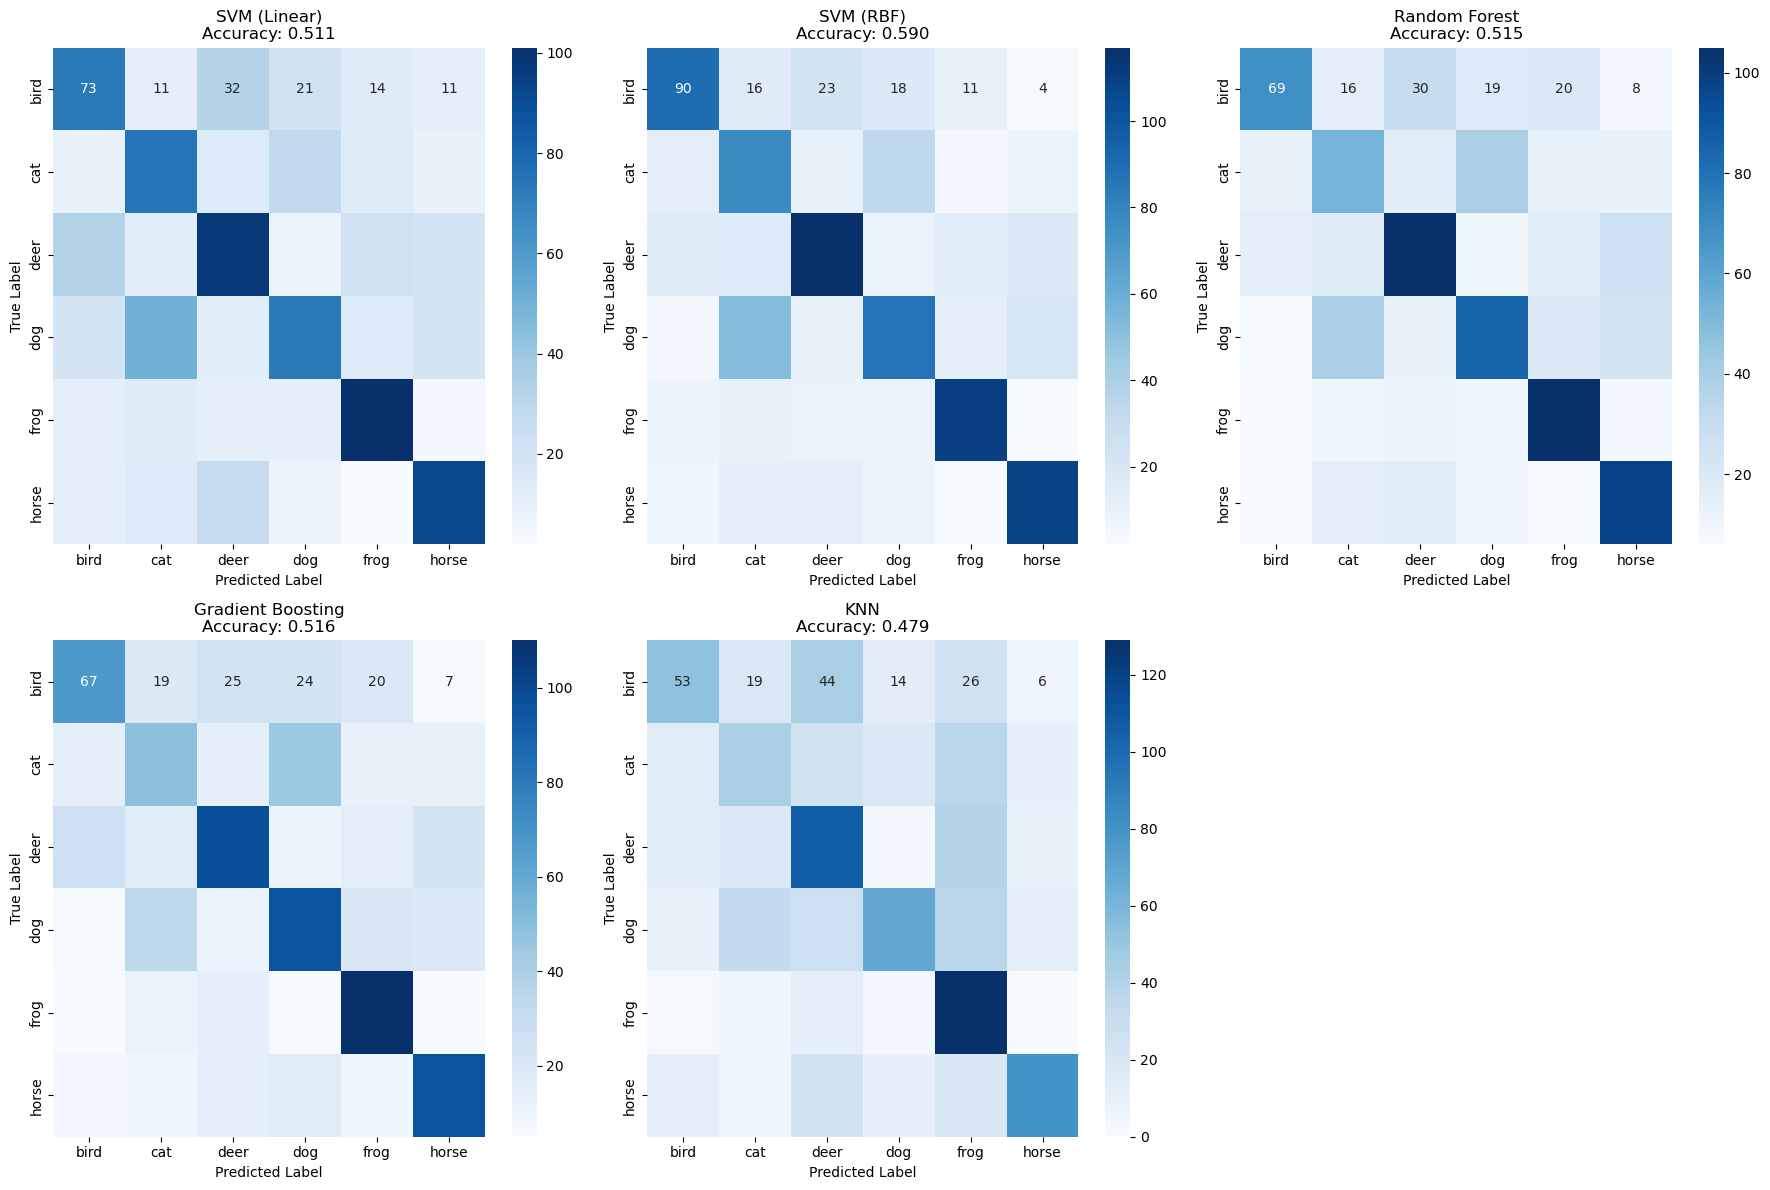

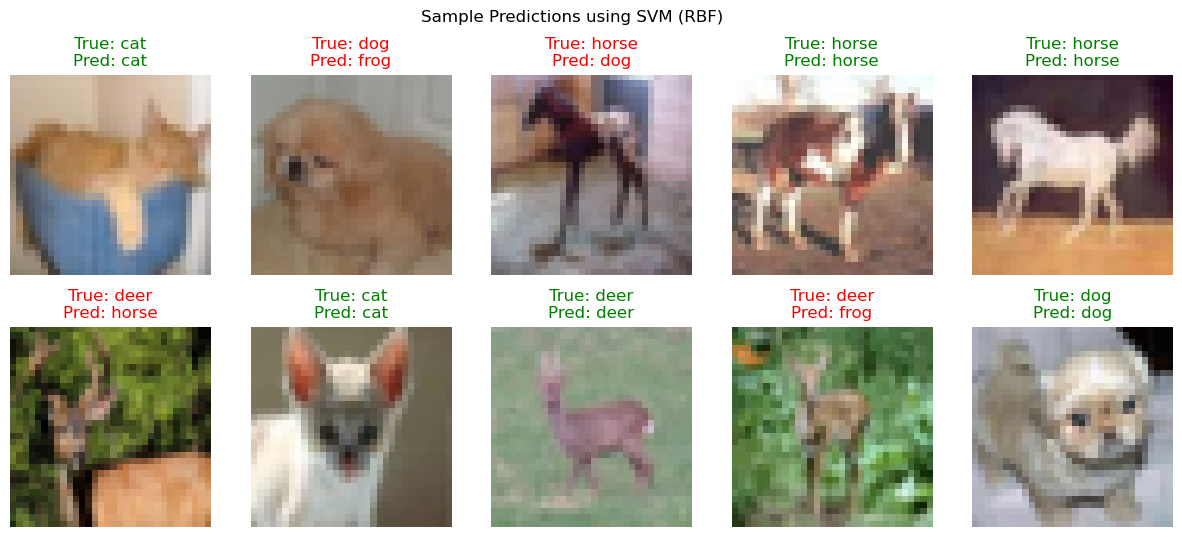

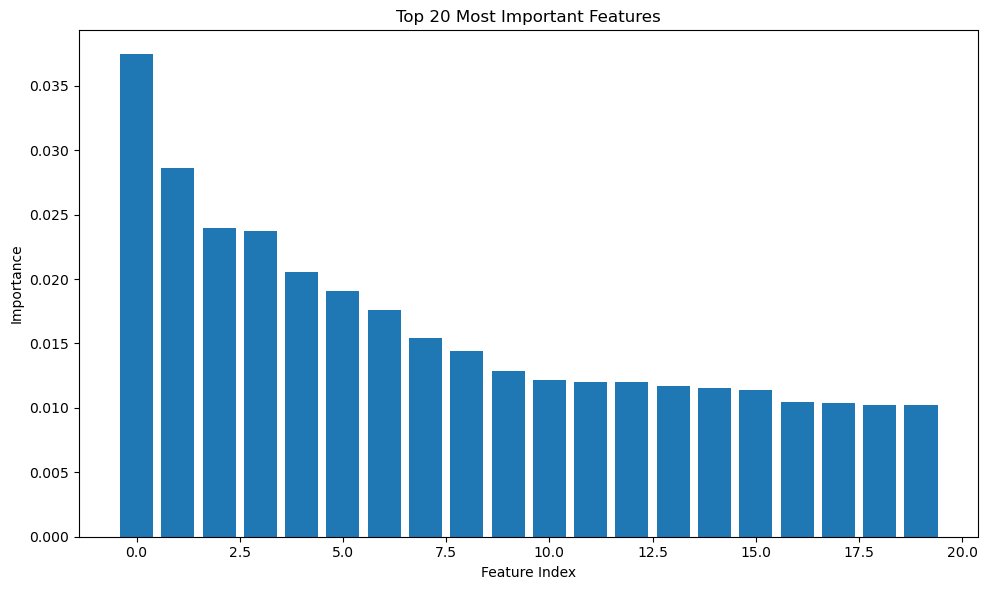

In [7]:
    # Train models
    classifier.train_models(X_train_features, y_train_subset, use_pca=True, n_components=100)
    
    # Evaluate models
    results = classifier.evaluate_models(X_test_features, y_test_subset)
    
    # Visualizations
    print("\n" + "="*60)
    print("VISUALIZATIONS")
    print("="*60)
    
    # 1. Confusion matrices
    classifier.plot_confusion_matrices(results, y_test_subset)
    
    # 2. Sample predictions
    classifier.visualize_predictions(X_test_subset, y_test_subset, results)
    
    # 3. Feature importance
    classifier.plot_feature_importance()

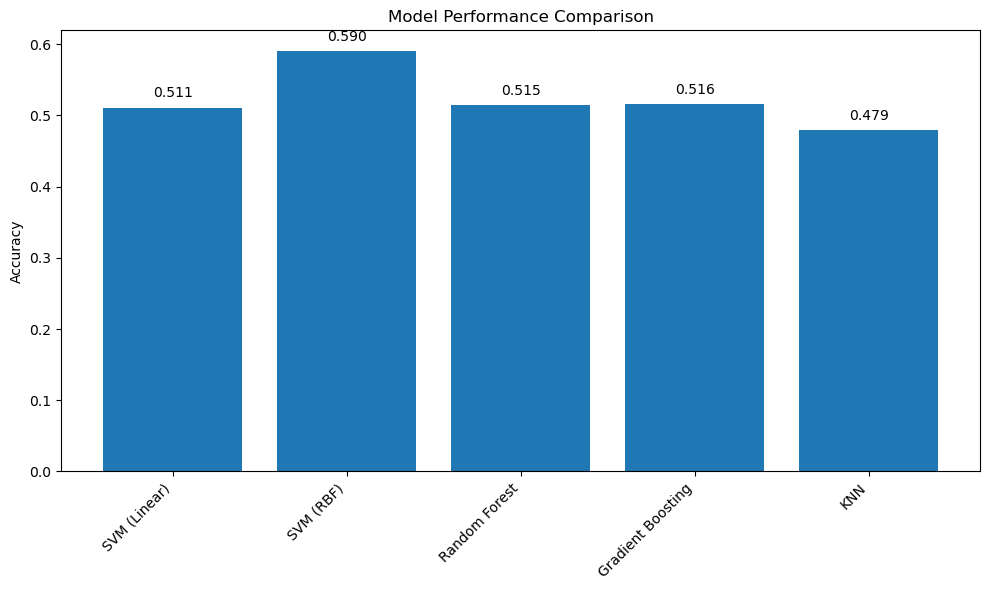

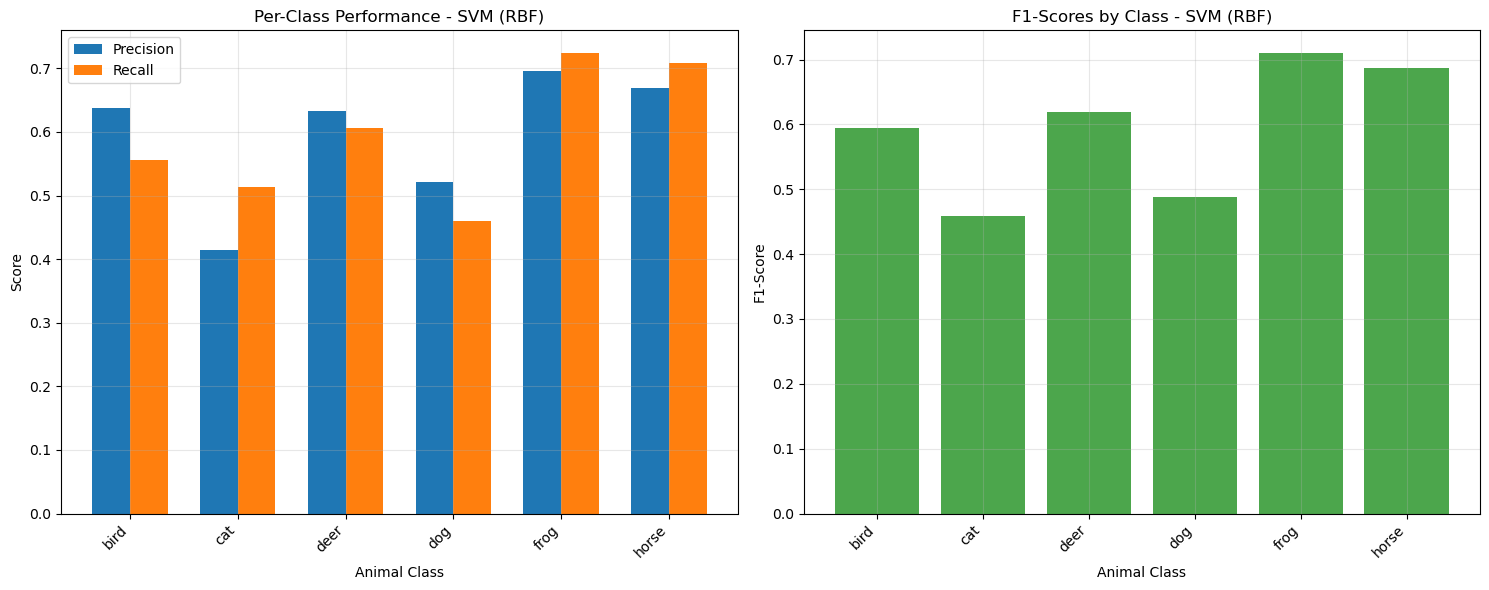

Models saved to cifar10_animal_classifier.pkl

ANALYSIS COMPLETE!

Best performing model: SVM (RBF)
Best accuracy: 0.5900

Most confused pair: dog misclassified as cat
Number of misclassifications: 52


In [8]:
    # 4. Model comparison
    plt.figure(figsize=(10, 6))
    model_names = list(results.keys())
    accuracies = [results[name]['accuracy'] for name in model_names]
    
    bars = plt.bar(model_names, accuracies)
    plt.ylabel('Accuracy')
    plt.title('Model Performance Comparison')
    plt.xticks(rotation=45, ha='right')
    
    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # 5. Per-class performance for best model
    best_model_name = max(results.items(), key=lambda x: x[1]['accuracy'])[0]
    best_report = results[best_model_name]['report']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Precision and Recall plot
    animals = list(classifier.animal_classes.values())
    precisions = [best_report[animal]['precision'] for animal in animals]
    recalls = [best_report[animal]['recall'] for animal in animals]
    
    x = np.arange(len(animals))
    width = 0.35
    
    ax1.bar(x - width/2, precisions, width, label='Precision')
    ax1.bar(x + width/2, recalls, width, label='Recall')
    ax1.set_xlabel('Animal Class')
    ax1.set_ylabel('Score')
    ax1.set_title(f'Per-Class Performance - {best_model_name}')
    ax1.set_xticks(x)
    ax1.set_xticklabels(animals, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # F1-score plot
    f1_scores = [best_report[animal]['f1-score'] for animal in animals]
    ax2.bar(animals, f1_scores, color='green', alpha=0.7)
    ax2.set_xlabel('Animal Class')
    ax2.set_ylabel('F1-Score')
    ax2.set_title(f'F1-Scores by Class - {best_model_name}')
    ax2.set_xticklabels(animals, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Save models
    classifier.save_models('cifar10_animal_classifier.pkl')
    
    # Print summary
    print("\n" + "="*60)
    print("ANALYSIS COMPLETE!")
    print("="*60)
    print("\nBest performing model:", best_model_name)
    print(f"Best accuracy: {results[best_model_name]['accuracy']:.4f}")
    
    # Print most confused pairs
    cm = results[best_model_name]['confusion_matrix']
    cm_copy = cm.copy()
    np.fill_diagonal(cm_copy, 0)  # Remove correct predictions
    max_confusion_idx = np.unravel_index(cm_copy.argmax(), cm_copy.shape)
    print(f"\nMost confused pair: {animals[max_confusion_idx[0]]} misclassified as {animals[max_confusion_idx[1]]}")
    print(f"Number of misclassifications: {cm_copy[max_confusion_idx]}")

In [13]:
import pickle

def save_everything(classifier, results, filename='cifar10_complete.pkl'):
    save_dict = {
        'classifier': classifier,
        'results': results,
        'models': classifier.models,
        'scaler': classifier.scaler,
        'pca': classifier.pca,
        'animal_classes': classifier.animal_classes
    }
    
    with open(filename, 'wb') as f:
        pickle.dump(save_dict, f)

# Save
save_everything(classifier, results, 'cifar10_complete.pkl')
print("Everything saved to cifar10_complete.pkl")

# Load later
with open('cifar10_complete.pkl', 'rb') as f:
    saved_data = pickle.load(f)
    loaded_classifier = saved_data['classifier']
    loaded_results = saved_data['results']

Everything saved to cifar10_complete.pkl


In [15]:
import pickle

# Read the saved models
with open('cifar10_complete.pkl', 'rb') as f:
    saved_data = pickle.load(f)

# See what's inside
print("Keys in saved data:", saved_data.keys())

# Extract individual components
models = saved_data['models']
scaler = saved_data['scaler']
pca = saved_data['pca']
animal_classes = saved_data['animal_classes']

# View model names
print("\nSaved models:")
for model_name in models.keys():
    print(f"  - {model_name}")

# View animal classes
print("\nAnimal classes:")
print(animal_classes)

Keys in saved data: dict_keys(['classifier', 'results', 'models', 'scaler', 'pca', 'animal_classes'])

Saved models:
  - SVM (Linear)
  - SVM (RBF)
  - Random Forest
  - Gradient Boosting
  - KNN

Animal classes:
{2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse'}


In [11]:
def create_pdf_report_flexible(classifier, results, filename='cifar10_report.pdf'):
    """Create PDF report without requiring test images"""
    
    with PdfPages(filename) as pdf:
        # Page 1: Title and Summary
        fig = plt.figure(figsize=(8.5, 11))
        fig.suptitle('CIFAR-10 Animal Classification Report', fontsize=20, fontweight='bold')
        
        ax = fig.add_subplot(111)
        ax.axis('off')
        
        # Summary text
        report_text = f"""
        Generated: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
        
        Models Evaluated: {len(results)}
        Best Model: {max(results.items(), key=lambda x: x[1]['accuracy'])[0]}
        Best Accuracy: {max(results.items(), key=lambda x: x[1]['accuracy'])[1]['accuracy']:.4f}
        
        Model Results:
        """
        
        for model_name, result in results.items():
            report_text += f"\n{model_name}: {result['accuracy']:.4f}"
        
        ax.text(0.1, 0.9, report_text, transform=ax.transAxes, 
                fontsize=12, verticalalignment='top', fontfamily='monospace')
        
        pdf.savefig(fig, bbox_inches='tight')
        plt.close()
        
        # Page 2: Model Comparison
        fig, ax = plt.subplots(figsize=(8.5, 6))
        
        model_names = list(results.keys())
        accuracies = [results[name]['accuracy'] for name in model_names]
        
        bars = ax.bar(model_names, accuracies, color='skyblue', edgecolor='navy')
        ax.set_ylabel('Accuracy', fontsize=12)
        ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
        ax.set_ylim(0, 1.1)
        
        for bar, acc in zip(bars, accuracies):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{acc:.3f}', ha='center', va='bottom')
        
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        pdf.savefig(fig, bbox_inches='tight')
        plt.close()
        
        # Page 3: Confusion Matrices
        n_models = len(results)
        fig = plt.figure(figsize=(8.5, 11))
        fig.suptitle('Confusion Matrices', fontsize=16, fontweight='bold')
        
        rows = (n_models + 1) // 2
        cols = 2
        
        animal_names = list(classifier.animal_classes.values())
        
        for idx, (name, result) in enumerate(results.items()):
            ax = plt.subplot(rows, cols, idx + 1)
            cm = result['confusion_matrix']
            
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=animal_names,
                       yticklabels=animal_names,
                       ax=ax, cbar_kws={'shrink': 0.8})
            
            ax.set_title(f'{name}\nAccuracy: {result["accuracy"]:.3f}', fontsize=10)
            ax.set_ylabel('True Label', fontsize=8)
            ax.set_xlabel('Predicted Label', fontsize=8)
            ax.tick_params(labelsize=7)
        
        plt.tight_layout()
        pdf.savefig(fig, bbox_inches='tight')
        plt.close()

# Use this simpler version
create_pdf_report_flexible(classifier, results, 'cifar10_report_simple.pdf')
print("Simplified PDF report saved!")

Simplified PDF report saved!
